# Advanced Analytics Training - Latent Dirichlet Allocation

# Table of contents
1. [Introduction to Bayesian Modelling](#introduction)
    1. [Bayes Rule](#br)
    2. [Conjugacy](#conjugacy)
2. [Latent Dirichlet Allocation](#lda)
    1. [Generative Model](#gm)
    2. [Joint Posterior](#df)
    3. [Discussion on Priors](#priors)
3. [Training LDA](#train_lda)
    1. [Gibbs Sampling](#gibbs)
    2. [Variational Inference](#vi)
4. [Topic evaluation](#te)
5. [References](#ref)

## Introduction to Bayesian Modelling <a name="introduction"></a>

Recently, due to the increasing need to reliably quantify the unceratinty of predictions in the machine learning algorithms, there has been a vast increase in popularity of Probabilistic Models, in both academia and industry. The specific examples of applications include:

* Topic Models 

* Hieararchical Models

* Bayesian Optimization 

This tutorial is focused on a particular type of the probabilistic generative topic model - the Latent Dirichlet Allocation. A user is first introduced to the key mathematical ideas required. Later, the main idea of Latent Dirichlet Allocation is introduced, followed by the overview of the relevant training algorithms. Techniques for model evaluation and comparison are then briefly discussed. Finally, some exercises and case studies are presented to ensure the understanding of the method.

### Bayes Rule <a name="br"></a>
In order to provide a more comprehensive review of the Bayesian modelling, let us here address several key mathematical concepts. Those already familiar with these concepts are free to skip this sub-section.

Let two $A$ and $B$ two events, then the `joint` probability of two events is given by

$$P(A,B) = P(A|B)P(B) = P(B|A)P(A),$$

which, when rearranged leads to the following identity, also known as the Bayes Rule,

$$ P(A | B) = \frac{P(B | A) \cdot P(A)}{P(B)}. $$

The Bayes Rule is the cornerstone of most probabilistc models. In order to understand its signifince, let $A$ represent a particular parameter $w$ of a given model and $B$ represent the data $D$ used for training. The Bayes Rule thus can be re-written as

$$ P(w | D) = \frac{P(D | w) \cdot P(w)}{P(D)}, $$
where 
* $P(w)$ is the prior distribution, which represents the probability of observing parameters values $w$ of the given model. Conceptually, prior distribution reflects someone's existing knowledge about the value of a given parameter.

* $P(D | w)$ is the likelihood function, which represent the probabiliity of oberving the data $D$, conditional on the parameter values $w$ of the model. The likelihood reflects fitting model to the data.

* $P(D)$ is the evidence, the probability of observing the data, which can be expressed as $\int P(D | w) \cdot P(w) dw$ in the continuous case by integrating out the paramter values.

* $P(w | D)$ is the posterior distibution, which represents probability of observing the parameter values $w$ of the given model, conditional on the data $D$. 

The $P(D)$ can be considered a normalisation constant to ensure that the posterior is a valid probability distribution, hence the common notation for the posterior

$$ P(w | D) \propto P(D | w) \cdot P(w). $$

The traditional statistical methods focus on optimising the value of the likelihood function for paramter values 

$$L = argmax_w(P(D|w))$$

and thus prove point estimates for parameteres values. Evaluating the posterior allows to obtain the probability distribution of the parameters rather than just point estimates, thus providing a more complete representation of the process and allowing to quantify the uncertainty of predictions. 
   
Having said that, evaluating the posterior tends to be much harder than computing likelihood, and, often not possible analytically. This is the main reason why, up until recenetly, with the development of robust posterior approximation algorithms, Bayesian models have not been utilised frequently to solve large-scale problems.

### Conjugacy <a name="conjugacy"></a>

In the context of Bayesian Modelling, conjugacy between the likelihood and the prior means that the probability distribution family of the prior and the posterior are the same. This property allows to compute the posterior analytically and, as we discuss furher, in some cases, to simplify the computations involved.

In order to explain the idea of conjugacy let us consider a famous Beta-Bernoulli model, which can be used to model the probability of sucess in a series of binary responce trials (e.g. coin tosses). Assume $X$ is a random variable corresponing to an outcome of a coin toss, where the probability of success(heads) is $p$. The probability of a success(heads) is then 

$$P(X = 1 | p) = p,$$

while the probability of a failure(tails) is

$$P(X = 0 | p) = 1-p.$$

Now, let there be $N$ such independent (conditionally on $p$) and identically distributed trials. The likelihood of oberving a given series of values is then given by 

$$P(X_1, X_2, ..., X_n|p) = \prod_{i=1}^{N} p^{X_i} \cdot (1-p)^{1-X_i}.$$

The posterior of $p$ therefore takes the form

$$P(p|X_1, X_2, ..., X_n)\propto\prod_{i=1}^{N} p^{X_i} \cdot (1-p)^{1-X_i} \cdot P(p),$$

where $P(p)$ is the prior on $p$. The form of the postrior and how easy it is to evaluate depends on the form of the prior. If the probability distribution of the prior is a $Beta(a,b)$, the posterior takes the form

$$P(p|X_1, X_2, ..., X_n)\propto\prod_{i=1}^{N} p^{X_i} \cdot (1-p)^{1-X_i} \cdot Beta(a,b) $$

$$P(p|X_1, X_2, ..., X_n)\propto\prod p^{\sum_i X_i} \cdot (1-p)^{N- \sum_i X_i} \cdot \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}p^{a-1}\cdot(1-p)^{b-1} \propto p^{a-1+\sum_i X_i}\cdot(1-p)^{b-1+N-\sum_i X_i}$$

The posterior here is a Beta distribution of the form  $Beta(a + \sum_i X_i, b+N-\sum_i X_i)$. This example shows how the conjugacy can be exploited to evaluate the posterior analytically.


The brief overview of the probability ideas presented in this chapter is by no means complete. An interested user is encourage to refer to the references at the end of the tutorial for a more complete discussion on the topic.

## Latent Dirichlet Allocation <a name="lda"></a>

Having  briefly discussed some of the required mathmaticla ideas, let us look at an important example of a probabilistic model - Latent Dirichlet Allocation. Latent Dirichlet Allocation (LDA) is probabllistic generative model that has been used to great success for information extraction and dimensionality reduction tasks.

### Generative Model <a name="gm"></a>

Consider a task of text generation, based on a given corpus of documents. Let the $n$-th word in the document $m$: $w_{n,m}$ in a given corpus take form of $V$-dimensional vector $\{1, ..., V \}$, such that $\{w^v =1\}$ and $w^u = 0$ for the $v$-th word, where $V$ is the size of the vocabulary. Consider each  document $\pmb{w} = \{w_1, ...w_V \}$ to be defined as a sequence of words. The whole corpus is then given by $D = \{\pmb{w_1}, ..., \pmb{w_M}\}$.

Each of the $M$ documents of length $N_m$ is assumed to be generated from a collection of $K$ topics $\theta_1, ..., \theta_K$. $\phi_k$ is therefore a $V$-dimensional probaility distribution of topic $k$ over the words in the vocabulary and $\theta_m$ is a $m$-dimensional probability distribution of document $m$ over the topics.
Let $z_{n,m}$ be the topic for the $n$-th word in the $m$-th document. $\alpha$ and $\beta$ are the Dirichlet prior parameters for $\theta_m$ and $\phi_k$ respectively. 

The generative model for LDA is as follows: 

* Sample a topic distribution for each document from a Dirchlet prior: $\theta_i \sim Dir(\alpha)$, where $i  \in \ \{1, ..., M\}$
 
* Sample a word distribution for each topic from a Dirchlet prior: $\phi_j \sim Dir(\beta)$, where $j  \in \ \{1, ..., K\}$

For each of the word in the corpus $w_{i,j}$, where $i \in \{1, ..., N_i\}$ and $j \in \{1, ..., M\}$

> Pick a topic using multinomial distribution:  $z_{i,j} \sim Multinomial(\theta_i)$
 
> Pick a word from the corresponding topic using the multinomial distribution $w_{i,j} \sim 
Multinomial(\phi_{z_{i,j}})$


### Joint Posterior <a name="jp"></a>

Conditioning on the fixed hyperparameters $\alpha$ and $\beta$ and assuming the length of all documents is $N$ (assumption is meant to simplify the notations, the results hold for the corpus with documents of varying lengths)  the joint posterior distribution of the parameters is given by

$$
P(\pmb{W}, \pmb{Z}, \pmb{\phi}, \pmb{\theta} | \alpha, \beta) = \prod_{k=1}^{K}P(\phi_k |\beta)\prod_{m=1}^{M}P(\theta_m|\alpha)\prod_{n=1}^{N_m}P(z_{n,m}|\theta_m)P(w_{n,m}|\phi_{z_{n,m}})\label{eq_joint}
$$

Solving the actual problem involves calculting the posterior of the $\theta$ and $\phi$, conditional on words $w_{m,n}$. To evaluate such distribution, one needs to compute the normalising constant, which is analytically intractable. In order to train the model, therefore, one has to apply specific algorithms are required, such as Collapsed Gibbs Sampling or Variatinal Inference. 

## Discussion on Priors <a name="priors"></a>

Let us briefly discuss the significance of Dirichlet priors in LDA. Dirichlet priors and conjugate to multinomial likelihood and, even though the posterior does not become analytically tractable, such choice of the prior distribution allows to significantly simplify the computations, as shown in the following section.

Dirichlet probability density fucntion is given by 
$$Dir(\theta | \alpha) = \frac{\Gamma(\sum_{i=1}^{k} \alpha_i)}{\prod_{i=1}^{k} \Gamma(\alpha_i)}\theta_1^{\alpha_1 - 1}... \theta_k^{\alpha_k - 1},$$
where $\alpha$ is a symmetric parameter.

In context of LDA, the choice of hyperparameters $\alpha$ and $\beta$ in the priors affects how the words are distributed within topics and topics are distributed within documents. Small hyperparameter values are most oftenly chosen as they result in sparse distribution of words within topic and topics within a dcoument. As the hyperparameter values approch $1$, the prior becomes uniform. As $\alpha$ grows the corresponding distribution becomes 'centred' and is likely to represent a mixture of topics/words. 

[None, None, None]

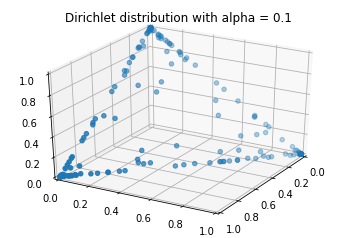

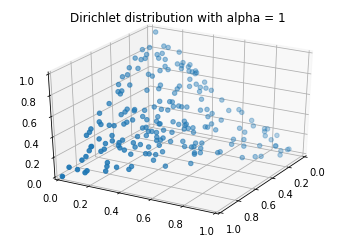

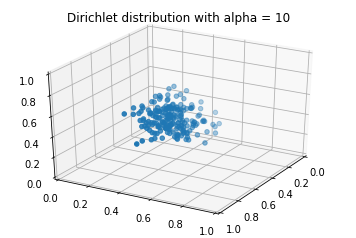

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import numpy as np

def plot_dirichlet_3d(alpha):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    s = np.random.dirichlet(np.repeat(alpha,3), 200)
    zdata = [crd[2] for crd in s]
    xdata = [crd[0] for crd in s]
    ydata = [crd[1] for crd in s]
    ax.scatter3D(xdata, ydata, zdata)
    ax.view_init(30, 30)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    plt.title('Dirichlet distribution with alpha = {}'.format(alpha))

alphas = [.1, 1, 10]
[plot_dirichlet_3d(alpha) for alpha in alphas]

## Training LDA <a name="train_lda"></a>

In this section several methods for training LDA are presented - Gibbs sampling and Variational Bayes. For each method the derivations are presented. The exercises in the end of the tutorial further focus on the practical side of applying these algorithms.

### Gibbs Sampling<a name="gibbs"></a>

Gibbs sampling is an example of the Markov Chain Monte Carlo (MCMC) methods. MCMC methods sample from posterior distribution, assiming that assymptotically the error between the sampled distribution and the true posterior is negligible. Consider a function to be evaluated, the as $N$ approaches infinity the expectation of $f(x)$ with respect to the probability distribution $p(x)$ can be approximated by sampling from it

$$E_{p(x)}f(x) \approx \frac{1}{N}\sum_{i=1}^{N}f(x_i).$$

In Gibbs Sampling, instead of evaluating the postrior distribution directly, we assume that the conditional distributions for each parameter can be evaluated. In this case, t the algorithm is initialised with some values of the parameters to be evluated. The conditionals are then sequentially updated, using the most recent parameter estimates.

Assume the data $D$ and two parameters describing the model $\beta_0^{(0)}$ and $\beta_1^{(0)}$, then 
1. Initialise the algorithm with some values of $\beta_0^{(0)}$ and $\beta_1^{(0)}$
2. for $i = 1,...,N$

    sample $\beta_0^{(i)} \sim P(\beta_0 | D, \beta_1^{(i-1)})$
    
    sample $\beta_1^{(i)} \sim P(\beta_1 | D, \beta_0^{(i)})$

In order to train LDA, we utilise collapsed Gibbs sampling, where, instead of utilising full conditionals, we can integrate $\theta$ and $\phi$ from the posterior and use a simpler joint denstiy of topic allocations  and words, due to the conjugacy between multinomial and Dirichlet distributions. The probability of a particular topic allocations, conditional on all other allocations and words is given by:

$$
P(z_{n,m} = k | z_{-n,m},\{w\}, \alpha, \beta) \propto \frac{\alpha + n^{(k)}_{-n,m}}{\sum_{j=1}^{K}\alpha + n^{(j)}_{-n,m}} \frac{\beta + \tilde{n}_{w_{-n,m}}^{k}}{\sum_{}^{}\beta + \tilde{n}_{w_{-n,m}}^{k}}
$$


### Variational Inference<a name="vi"></a>

Variational inference (VI) is another family of approaches of evaluating the posterior distribution. Unlike, MCMC methods, however, VI aims to transform the initial problem into an optimization problem, where 

## Topic Evaluation <a name="te"></a>

* Intro
* Perplexity
* Coherence

## References <a name="lda"></a>


In this tutorial some of the details in the derivations have been ommited, please consider spending more time
End of the chapter, recommend chapters from selected books -  Bishop, Baker, Murphy.

## Implement Gibbs Sampling

In [74]:
import operator
from functools import reduce
import numpy as np
from collections import OrderedDict

In [83]:
# Sample Documents
documents = ['eat turkey on turkey day holiday',
          'i like to eat cake on holiday',
          'turkey trot race on thanksgiving holiday',
          'snail race the turtle',
          'time travel space race',
          'movie on thanksgiving',
          'movie at air and space museum is cool movie',
          'aspiring movie star']

documents = [doc.split(' ') for doc in documents]
## Create Vocabulary
vocabulary = reduce(operator.concat, documents)
vocabulary = reduce(lambda l, x: l+[x] if x not in l else l, vocabulary, [])
## Id Assigned Vocabulary
vocabulary = OrderedDict([(vocabulary[i],i) for i in range(len(vocabulary))])
## Id Assigned Document
def assign_ids(document, vocabulary):
    return [vocabulary[word] for word in document]

documents_with_ids = [assign_ids(doc, vocabulary) for doc in documents]

In [38]:
## PARAMETERS
K = 2 # number of topics
alpha = 1 # hyperparameter. single value indicates symmetric dirichlet prior. higher=>scatters document clusters
eta = .001 # hyperparameter for Posson Sampling
iterations = 3 # iterations for collapsed gibbs sampling.  This should be a lot higher than 3 in practice.

In [171]:
## 1. Randomly assign topics to words in each doc. 
## 2. Generate word-topic count matrix.
word_topic = np.zeros([K, len(vocabulary)])  # initialize word-topic count matrix
topic_assignment = np.array([np.zeros(len(doc)) for doc in documents_with_ids]) # initialize topic assignment list
for d in range(len(documents_with_ids)): # for each document
    for w in range(len(documents_with_ids[d])): # for each token in document d
        topic_assignment[d][w] = np.random.randint(0,K,1) # randomly assign topic to token w.
        ti = topic_assignment[d][w] # topic index
        wi = documents_with_ids[d][w] # wordID for token w
        word_topic[np.int(ti),wi] +=1 # update word-topic count matrix     
  


In [172]:
# Generate a Document-topic matrix

document_topic = np.zeros([len(documents_with_ids), K])
for d in range(len(documents_with_ids)): # for each document d
    for t in range(K): # for each topic t
        document_topic[d,t] = np.sum(topic_assignment[d] == t) # count tokens in document d assigned to topic t   

In [173]:
# Gibbs sampling
for i in range(iterations): # for each pass through the corpus
    for d in range(len(documents_with_ids)): # for each document
        for w in range(len(documents_with_ids[d])): # for each token 
      
            t0 = np.int(topic_assignment[d][w]) # initial topic assignment to token w
            wid = np.int(documents_with_ids[d][w]) # wordID of token w
            document_topic[d,t0] -= 1 # we don't want to include token w in our document-topic count matrix when sampling for token w
            word_topic[t0,wid] -= 1 # we don't want to include token w in our word-topic count matrix when sampling for token w

            ## UPDATE TOPIC ASSIGNMENT FOR EACH WORD -- COLLAPSED GIBBS SAMPLING MAGIC.  Where the magic happens.
            denom_a = np.sum(document_topic[d,:]) + K * alpha # number of tokens in document + number topics * alpha
            denom_b = np.sum(word_topic, axis=1) + len(vocabulary) * eta # number of tokens in each topic + # of words in vocab * eta
            p_z = (word_topic[:,wid] + eta)/denom_b*(document_topic[d,:] + alpha)/denom_a # calculating probability word belongs to each topic
            t1 = np.random.choice(list(range(K)), p=p_z/sum(p_z)) # draw topic for word n from multinomial using probabilities calculated above

            topic_assignment[d][w] = t1 # update topic assignment list with newly sampled topic for token w.
            document_topic[d,t1] += 1 # re-increment document-topic matrix with new topic assignment for token w.
            word_topic[t1,wid] += 1 #re-increment word-topic matrix with new topic assignment for token w.

            if t0!=t1:
                print('doc:', d, ' token:' ,w, ' topic:',t0,'=>',t1) # examine when topic assignments change


doc: 0  token: 1  topic: 0 => 1
doc: 0  token: 2  topic: 0 => 1
doc: 0  token: 3  topic: 1 => 0
doc: 0  token: 5  topic: 1 => 0
doc: 1  token: 0  topic: 0 => 1
doc: 1  token: 1  topic: 0 => 1
doc: 2  token: 0  topic: 0 => 1
doc: 2  token: 1  topic: 1 => 0
doc: 2  token: 2  topic: 1 => 0
doc: 2  token: 4  topic: 0 => 1
doc: 3  token: 1  topic: 0 => 1
doc: 3  token: 2  topic: 1 => 0
doc: 4  token: 0  topic: 0 => 1
doc: 4  token: 3  topic: 1 => 0
doc: 5  token: 0  topic: 1 => 0
doc: 6  token: 1  topic: 0 => 1
doc: 6  token: 3  topic: 1 => 0
doc: 6  token: 5  topic: 0 => 1
doc: 6  token: 8  topic: 1 => 0
doc: 0  token: 1  topic: 1 => 0
doc: 1  token: 1  topic: 1 => 0
doc: 1  token: 2  topic: 1 => 0
doc: 2  token: 0  topic: 1 => 0
doc: 3  token: 1  topic: 1 => 0
doc: 3  token: 2  topic: 0 => 1
doc: 3  token: 3  topic: 0 => 1
doc: 4  token: 1  topic: 1 => 0
doc: 5  token: 0  topic: 0 => 1
doc: 6  token: 0  topic: 1 => 0
doc: 6  token: 1  topic: 1 => 0
doc: 6  token: 2  topic: 1 => 0
doc: 6  

In [181]:
theta = [(document_topic+alpha)[i] / np.sum(document_topic+alpha, axis=1)[i] for i in range(len(documents_with_ids))] # topic probabilities per document
print(theta)

[array([0.625, 0.375]), array([0.55555556, 0.44444444]), array([0.625, 0.375]), array([0.33333333, 0.66666667]), array([0.66666667, 0.33333333]), array([0.4, 0.6]), array([0.63636364, 0.36363636]), array([0.8, 0.2])]


In [186]:
phi = [(word_topic+eta)[i] / np.sum(word_topic+eta, axis=1)[i] for i in range(2)] # topic probabilities per document
print(phi)

[array([3.84216391e-05, 1.15303339e-01, 3.84216391e-05, 3.84600607e-02,
       1.15303339e-01, 3.84600607e-02, 3.84600607e-02, 3.84216391e-05,
       3.84600607e-02, 3.84600607e-02, 1.15303339e-01, 3.84216391e-05,
       3.84216391e-05, 3.84216391e-05, 3.84216391e-05, 3.84216391e-05,
       3.84600607e-02, 7.68816998e-02, 1.53724978e-01, 3.84216391e-05,
       3.84216391e-05, 3.84216391e-05, 3.84600607e-02, 3.84600607e-02,
       3.84600607e-02, 3.84600607e-02, 3.84600607e-02]), array([1.24851813e-01, 6.23947089e-05, 2.49641230e-01, 6.23947089e-05,
       6.23947089e-05, 6.23947089e-05, 6.23947089e-05, 6.24571036e-02,
       6.23947089e-05, 6.23947089e-05, 6.23947089e-05, 1.24851813e-01,
       6.24571036e-02, 6.24571036e-02, 6.24571036e-02, 6.24571036e-02,
       6.23947089e-05, 6.23947089e-05, 6.23947089e-05, 6.24571036e-02,
       6.24571036e-02, 6.24571036e-02, 6.23947089e-05, 6.23947089e-05,
       6.23947089e-05, 6.23947089e-05, 6.23947089e-05])]


## Using gensim